<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

## Get the data (PUBMED DATASET)

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 38.34 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data

In [7]:
def get_lines(filename):
  """
    Reads the file name and returns the
    lines of text as a list.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [8]:
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

In [9]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # Start of the new abstract
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [10]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

In [10]:
%%time
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


(180040, 30212, 30135)

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [13]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [12]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_label_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Encode Lables

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

In [15]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [16]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0 - Create Baseline Model

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate
model_0.score(X=val_sentences,
                y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions using out baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [18]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-06 18:25:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-06 18:25:58 (87.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [19]:
from helper_functions import calculate_results

In [24]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 1
* Preparing data for deep sequence model
1. Create vectorization layer
2. Create embedding layers

In [37]:
from tensorflow.keras import layers

In [36]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [38]:
import matplotlib.pyplot as plt

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

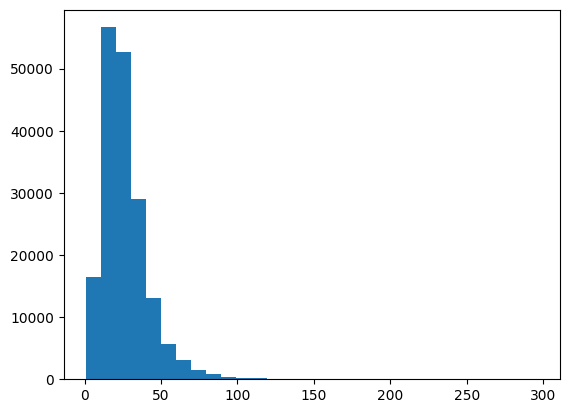

In [39]:
plt.hist(sent_lens, bins=30)

In [40]:
# How long of a sentence length covers 95% of example?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# 95% of the sentences are under length 55

### Model 1: Text Vectorization (Tokenization)
* Tokenization is direct mapping from token to numbers

In [41]:
max_vocab_length = 68000 # max number of words to have in vocabulary
max_length = output_seq_len

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                               output_mode='int',
                                               output_sequence_length=max_length)

# Without adapt method or fitting the train_sentences the text_vectorization layer won't work
# On input sentences
train_vectorized = text_vectorizer.adapt(train_sentences)

In [42]:
import random
target_sentence = random.choice(train_sentences)
print(f"{len(target_sentence.split())}")
print(f"{target_sentence}")
x = text_vectorizer([target_sentence])
print(f"{x}")

15
the clinical and on going pregnancy rates per cycle and per patient were evaluated .
[[    2    47     3    18 10334   540   162   160  1299     3   160   127
      9   184     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [43]:
len(text_vectorizer.get_vocabulary())

64841

### Model 1: Text Embedding

In [34]:
embedding_layer = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                                            output_dim=128,
                                            input_length=output_seq_len,
                                            mask_zero=True)

In [35]:
embedding_layer

In [36]:
y = embedding_layer(text_vectorizer([train_sentences[0]]))
y

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.0171293 ,  0.01925686,  0.00683095, ...,  0.04112751,
          0.04040999, -0.01405974],
        [ 0.03002704, -0.04593794,  0.02237106, ...,  0.02522494,
          0.01253047,  0.03348538],
        [-0.01568823,  0.01145189,  0.00303887, ..., -0.04212736,
         -0.01978499, -0.04415468],
        ...,
        [-0.00706004, -0.01954652, -0.02869061, ..., -0.01092301,
          0.00756031, -0.03878625],
        [-0.00706004, -0.01954652, -0.02869061, ..., -0.01092301,
          0.00756031, -0.03878625],
        [-0.00706004, -0.01954652, -0.02869061, ..., -0.01092301,
          0.00756031, -0.03878625]]], dtype=float32)>

### Creating tensorflow datasets for model
* This loads the data faster because of tf dataset apis internal optimizations

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_label_one_hot))

### Create datasets into prefetched datasets

In [38]:
# Shuffle is not used here because we want to preserve the sequence of sentences for task
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Conv1D Model with token embedding

In [39]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = embedding_layer(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

In [41]:
history_model_1 = model_1.fit(train_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 22s 31ms/step - loss: 0.9285 - accuracy: 0.6297 - val_loss: 0.6860 - val_accuracy: 0.7387
Epoch 2/5
562/562 [==============================] - 6s 11ms/step - loss: 0.6553 - accuracy: 0.7577 - val_loss: 0.6308 - val_accuracy: 0.7736
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.6141 - accuracy: 0.7770 - val_loss: 0.5924 - val_accuracy: 0.7869
Epoch 4/5
562/562 [==============================] - 4s 6ms/step - loss: 0.5853 - accuracy: 0.7915 - val_loss: 0.5758 - val_accuracy: 0.7926
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5883 - accuracy: 0.7919 - val_loss: 0.5591 - val_accuracy: 0.8015


In [42]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5586 - accuracy: 0.8015


[0.5585869550704956, 0.801469624042511]

In [43]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[5.4590565e-01, 1.7794150e-01, 4.4222679e-02, 1.6826190e-01,
         6.3668296e-02],
        [4.2283878e-01, 3.7711519e-01, 2.5331190e-02, 1.3688745e-01,
         3.7827406e-02],
        [1.7717136e-01, 5.0043552e-03, 1.2179316e-03, 8.1656516e-01,
         4.1193216e-05],
        ...,
        [4.7697504e-05, 8.5015531e-04, 3.7441580e-03, 3.8479477e-05,
         9.9531955e-01],
        [9.2596591e-02, 2.5362909e-01, 1.3765684e-01, 6.2569074e-02,
         4.5354843e-01],
        [1.3427402e-01, 7.6977634e-01, 5.5426035e-02, 1.5881088e-02,
         2.4642406e-02]], dtype=float32),
 (30212, 5))

In [44]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [45]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.14696147226267,
 'precision': 0.8014519713529807,
 'recall': 0.8014696147226268,
 'f1': 0.7986011141022104}

# Model 2-  Tensorflow Hub Pretrained Feature Extractor

In [44]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [45]:
# Test our pretrained embeddings
random_training_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_training_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding: {use_embedded_sentence[0][:30]}")

Random sentence: among the @/@ ( @ % ) patients who had their qe on at , the @-year primary end point rates were @ % for those randomized to amm ( n = @ ) and @ % for ptas ( n = @ ; p = @ , log-rank test ) .
Sentence after embedding: [ 0.01319551 -0.08083296 -0.00456938 -0.0629011  -0.07026746 -0.00183337
  0.06134627  0.02075499 -0.06926862 -0.00501038  0.08182581  0.01786746
  0.06741908  0.03555672  0.04524954 -0.01943783 -0.08108743  0.00767721
  0.04369393 -0.04394639  0.05887591 -0.0044491  -0.062937    0.01493311
 -0.00173009  0.03081134 -0.01366838 -0.04038095  0.04805129 -0.01681825]


In [48]:
use_embedded_sentence.shape

TensorShape([1, 512])

In [49]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_2 = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 0.9200 - accuracy: 0.6483 - val_loss: 0.7959 - val_accuracy: 0.6915
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7692 - accuracy: 0.7008 - val_loss: 0.7552 - val_accuracy: 0.7061
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7536 - accuracy: 0.7126 - val_loss: 0.7403 - val_accuracy: 0.7111
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7205 - accuracy: 0.7239 - val_loss: 0.7117 - val_accuracy: 0.7284
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7281 - accuracy: 0.7217 - val_loss: 0.6901 - val_accuracy: 0.7344


In [50]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.6994 - accuracy: 0.7334


[0.6993570327758789, 0.7333509922027588]

### Observe the trainable parameters in both models

In [51]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

In [52]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [53]:
model_2_preds_probs = model_2.predict(val_dataset)
model_2_preds_probs

945/945 [==============================] - 10s 10ms/step


array([[6.5279716e-01, 2.3857424e-01, 2.1837081e-03, 9.6650869e-02,
        9.7940452e-03],
       [4.6389362e-01, 4.2798600e-01, 6.9783148e-03, 9.8629750e-02,
        2.5123153e-03],
       [3.5447592e-01, 8.1457749e-02, 4.6777826e-02, 4.6476534e-01,
        5.2523214e-02],
       ...,
       [2.0510189e-03, 2.7516298e-03, 1.0175712e-01, 7.1766105e-04,
        8.9272261e-01],
       [2.7712316e-03, 2.1983281e-02, 4.9200439e-01, 8.4398617e-04,
        4.8239705e-01],
       [1.5954009e-01, 3.3167851e-01, 4.6433762e-01, 2.5914952e-03,
        4.1852366e-02]], dtype=float32)

In [54]:
model_2_preds_probs.shape

(30212, 5)

In [55]:
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 2])>

In [56]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.33509863630346,
 'precision': 0.7298062873743163,
 'recall': 0.7333509863630345,
 'f1': 0.727653905570595}

## Conv1D with Character embeddings

In [59]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'a m o n g   t h e   @ / @   (   @   %   )   p a t i e n t s   w h o   h a d   t h e i r   q e   o n   a t   ,   t h e   @ - y e a r   p r i m a r y   e n d   p o i n t   r a t e s   w e r e   @   %   f o r   t h o s e   r a n d o m i z e d   t o   a m m   (   n   =   @   )   a n d   @   %   f o r   p t a s   (   n   =   @   ;   p   =   @   ,   l o g - r a n k   t e s t   )   .'

In [60]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [61]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [62]:
chars_length = [len(sentence) for sentence in train_sentences]
mean_chars_length = np.mean(chars_length)
mean_chars_length

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

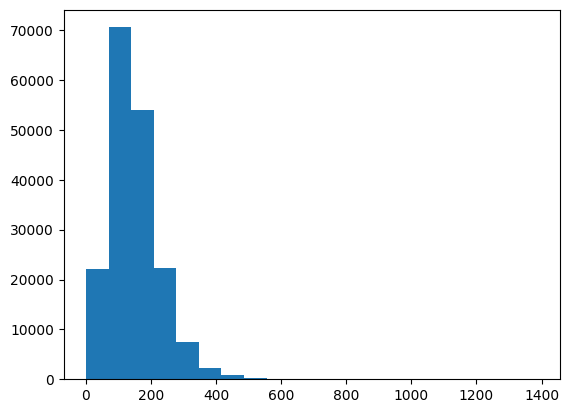

In [63]:
import matplotlib.pyplot as plt

plt.hist(chars_length, bins=20)

In [64]:
output_seq_char_len = np.percentile(chars_length, 95)

In [65]:
output_seq_char_len

290.0

In [66]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [67]:
len(alphabet)

68

In [68]:
MAX_CHAR_TOKENS = len(alphabet) + 2 # for padding and unknown token
char_vectorizer = layers.TextVectorization(max_tokens=MAX_CHAR_TOKENS,
                                             output_sequence_length=int(output_seq_char_len),
                                             standardize="lower_and_strip_punctuation",
                                             name="char_vectorizer",
                                           )

In [69]:
char_vectorizer.adapt(train_chars)

In [70]:
char_vocabs = char_vectorizer.get_vocabulary()
print(x)

tf.Tensor(
[[    2    47     3    18 10334   540   162   160  1299     3   160   127
      9   184     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)


In [74]:
char_vectorizer(random.choice(train_chars))

<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([17,  7, 16,  8, 10,  4, 17, 17,  2,  8,  2,  6,  3,  9,  2,  3,  9,
        7, 17,  2, 24, 14, 12,  5,  6,  5,  3,  7,  8, 19, 21,  5,  8,  4,
        5, 22, 12,  2,  9, 20,  2,  8,  2, 11,  7, 15, 14,  5,  8,  2, 10,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [75]:
len(char_vectorizer(random.choice(train_chars)))

290

In [76]:
embedding_char = layers.Embedding(input_dim=len(char_vocabs),
                                  output_dim=25,
                                  mask_zero=False,
                                  name="char_embedding")

In [77]:
x_embedding = embedding_char(char_vectorizer([random.choice(train_chars)]))

In [78]:
x_embedding

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[-1.5753318e-02, -7.7962875e-05, -5.2076578e-04, ...,
          3.9186601e-02, -1.4510453e-02,  4.1024555e-02],
        [-8.3847530e-03,  2.6407097e-02, -2.9615140e-02, ...,
          7.5260885e-03,  4.7925700e-02,  1.8187176e-02],
        [ 1.3081994e-02, -4.7862388e-02, -1.6796090e-02, ...,
          2.3285400e-02,  2.0310152e-02, -4.6327520e-02],
        ...,
        [-4.9652457e-03,  2.2352170e-02,  8.3720088e-03, ...,
         -1.3870485e-03, -4.5556117e-02,  3.9464235e-04],
        [-4.9652457e-03,  2.2352170e-02,  8.3720088e-03, ...,
         -1.3870485e-03, -4.5556117e-02,  3.9464235e-04],
        [-4.9652457e-03,  2.2352170e-02,  8.3720088e-03, ...,
         -1.3870485e-03, -4.5556117e-02,  3.9464235e-04]]], dtype=float32)>

# Model 3

In [74]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = embedding_char(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [76]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


history_model_3 = model_3.fit(train_char_dataset,
            epochs=5,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            validation_data=val_char_dataset,
            validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 5s 6ms/step - loss: 1.2684 - accuracy: 0.4826 - val_loss: 1.0497 - val_accuracy: 0.5788
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.0074 - accuracy: 0.5932 - val_loss: 0.9328 - val_accuracy: 0.6313
Epoch 3/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9152 - accuracy: 0.6422 - val_loss: 0.8579 - val_accuracy: 0.6742
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8634 - accuracy: 0.6635 - val_loss: 0.8308 - val_accuracy: 0.6782
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8454 - accuracy: 0.6726 - val_loss: 0.8141 - val_accuracy: 0.6938


In [77]:
model_3.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 1.6920 - accuracy: 0.3883


[1.6919935941696167, 0.38832253217697144]

In [78]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.17302349, 0.5656169 , 0.07735289, 0.16097167, 0.02303505],
       [0.17850515, 0.7269571 , 0.01271059, 0.06664761, 0.01517958],
       [0.15154946, 0.36166808, 0.0909344 , 0.38467413, 0.01117394],
       ...,
       [0.01117598, 0.08183752, 0.06636259, 0.0193731 , 0.8212508 ],
       [0.05121662, 0.0955997 , 0.28730473, 0.05579452, 0.5100844 ],
       [0.26135802, 0.60849315, 0.10306948, 0.01416633, 0.012913  ]],
      dtype=float32)

In [79]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [80]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 68.39666357738648,
 'precision': 0.6895081462370324,
 'recall': 0.6839666357738647,
 'f1': 0.6803751668774407}

# Model 4 - Concat token-level embedding and character-level embedding

In [81]:
# 1. setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu', name="token_output")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output, name="token_model")

# 2. setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = embedding_char(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name="char_output")(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")

# 3. combine token model and character model by concatenation
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers adding in a dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)


model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [82]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

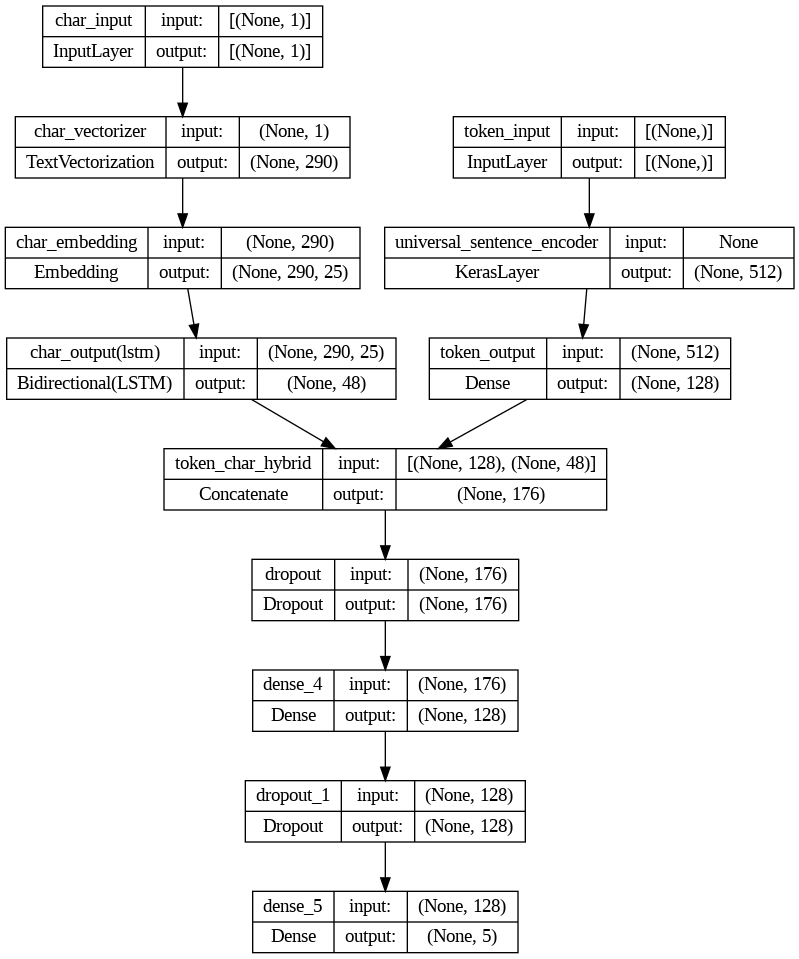

In [83]:
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [84]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_char_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


In [85]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 36s 52ms/step - loss: 0.9865 - accuracy: 0.6063 - val_loss: 0.7803 - val_accuracy: 0.7031
Epoch 2/5
562/562 [==============================] - 18s 32ms/step - loss: 0.8031 - accuracy: 0.6904 - val_loss: 0.7196 - val_accuracy: 0.7294
Epoch 3/5
562/562 [==============================] - 19s 33ms/step - loss: 0.7772 - accuracy: 0.7037 - val_loss: 0.6926 - val_accuracy: 0.7330
Epoch 4/5
562/562 [==============================] - 27s 49ms/step - loss: 0.7451 - accuracy: 0.7215 - val_loss: 0.6721 - val_accuracy: 0.7447
Epoch 5/5
562/562 [==============================] - 21s 38ms/step - loss: 0.7486 - accuracy: 0.7189 - val_loss: 0.6547 - val_accuracy: 0.7503


In [86]:
model_4.evaluate(val_char_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6611 - accuracy: 0.7475


[0.6611146926879883, 0.7474844455718994]

In [87]:
model_4_pred_probs = model_4.predict(val_char_dataset)
model_4_pred_probs

945/945 [==============================] - 17s 17ms/step


array([[5.9114623e-01, 2.0918617e-01, 2.4686838e-03, 1.9062096e-01,
        6.5779043e-03],
       [5.1566470e-01, 3.5031721e-01, 5.5412455e-03, 1.2590720e-01,
        2.5695956e-03],
       [3.7364134e-01, 7.6026469e-02, 5.5657692e-02, 4.6959692e-01,
        2.5077527e-02],
       ...,
       [1.2332460e-04, 1.3136002e-03, 5.9930738e-02, 6.8365174e-05,
        9.3856400e-01],
       [4.7036204e-03, 2.8970113e-02, 3.1751862e-01, 2.2311918e-03,
        6.4657646e-01],
       [2.4204819e-01, 4.4079086e-01, 2.6063639e-01, 1.8333962e-02,
        3.8190577e-02]], dtype=float32)

In [88]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [89]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.74844432675758,
 'precision': 0.7444284539137271,
 'recall': 0.7474844432675758,
 'f1': 0.7426906509026361}

# Model 5 - Char Embedding + Pretrained token Embedding + Positional Embedding


In [22]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Create positional embeddings

In [21]:
# How many different line numbers are there
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

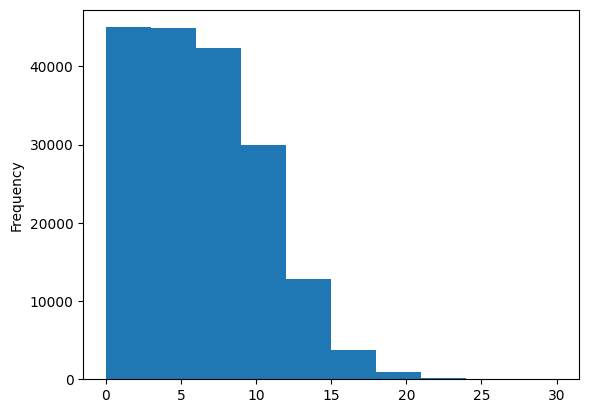

In [23]:
train_df.line_number.plot.hist()

In [24]:
# One hot encode the line_number feature using Tensorflow

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [25]:
train_line_numbers_one_hot[:3]

<tf.Tensor: shape=(3, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [26]:
train_line_numbers_one_hot.shape

TensorShape([180040, 15])

In [27]:
# One hot encode total_lines feature

train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

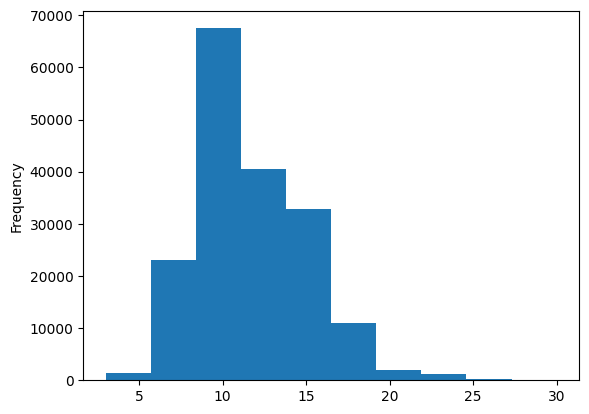

In [28]:
train_df.total_lines.plot.hist()

In [29]:
np.percentile(train_df.total_lines, 98)

20.0

In [30]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [31]:
train_total_lines_one_hot[0:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [79]:
from tensorflow.keras import layers

# 1. Create a token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")


# 2. Create a char-level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = embedding_char(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")


# 3. Create a model for "line-number" feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x, name="line_number_model")


# 4. Create a model for "total_lines" feature
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y, name="total_lines_model")

# 5. Combine 1 & 2
combined_embeddings = layers.Concatenate(name="combine_embeddings")([token_model.output,
                                                                    char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)


# 6. Combine 5, 3 and 4
tribrid_embeddings = layers.Concatenate(name="tribrid_embeddings")([line_number_model.output,
                                                                    total_lines_model.output,
                                                                    z])

output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                     total_lines_model.input,
                                     token_model.input,
                                     char_model.input
                                     ],
                              outputs=output_layer)

In [80]:
model_5.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']     

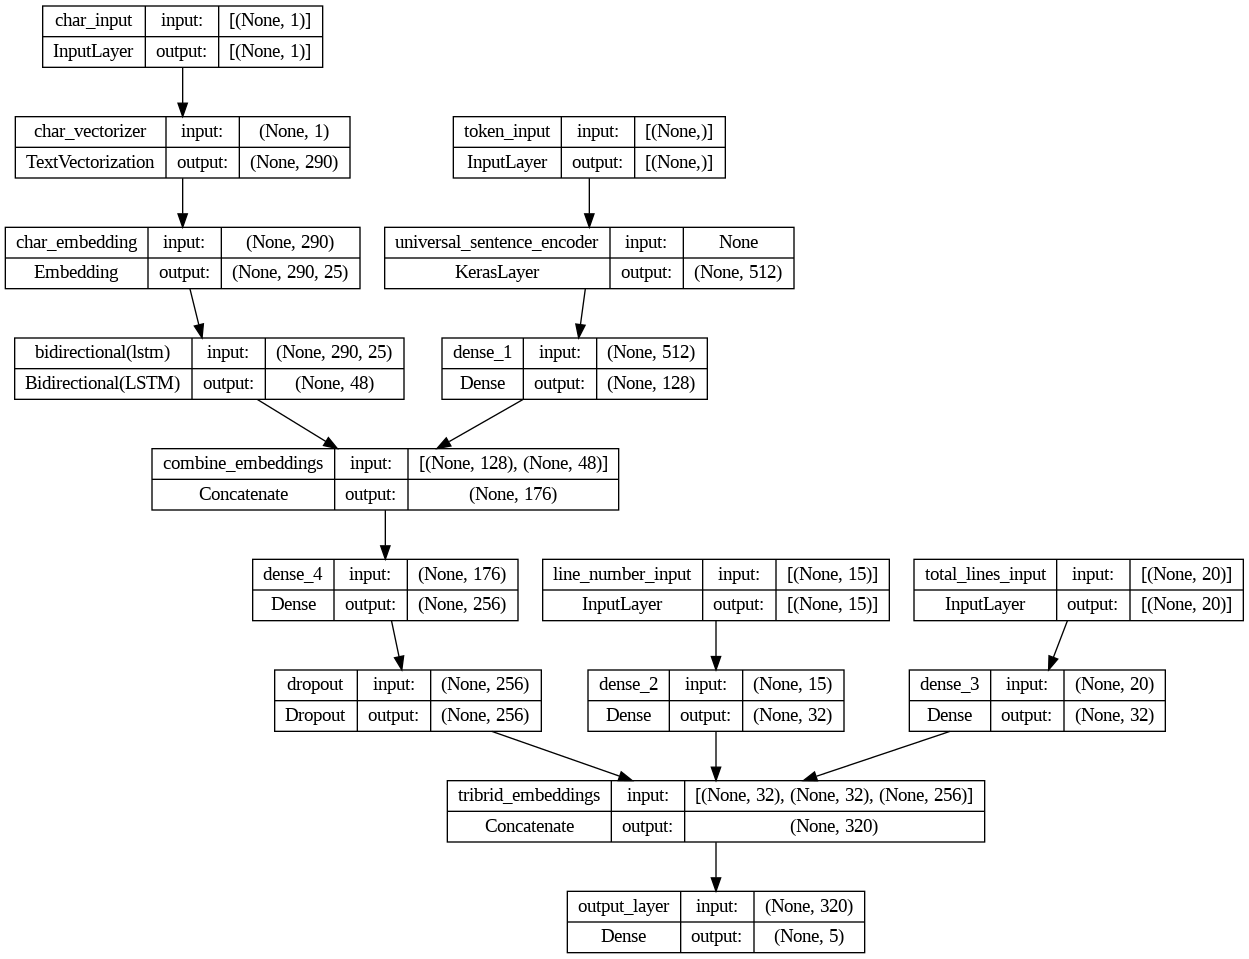

In [81]:
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [85]:
 model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                                  optimizer=tf.keras.optimizers.Adam(),
                                  metrics=["accuracy"])

In [86]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_char_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)




In [92]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 142s 237ms/step - loss: 1.1017 - accuracy: 0.7193 - val_loss: 0.9844 - val_accuracy: 0.8039
Epoch 2/5
562/562 [==============================] - 149s 265ms/step - loss: 0.9707 - accuracy: 0.8127 - val_loss: 0.9538 - val_accuracy: 0.8261
Epoch 3/5
562/562 [==============================] - 130s 230ms/step - loss: 0.9535 - accuracy: 0.8220 - val_loss: 0.9420 - val_accuracy: 0.8271
Epoch 4/5
562/562 [==============================] - 127s 227ms/step - loss: 0.9427 - accuracy: 0.8334 - val_loss: 0.9335 - val_accuracy: 0.8338
Epoch 5/5
562/562 [==============================] - 119s 211ms/step - loss: 0.9387 - accuracy: 0.8349 - val_loss: 0.9239 - val_accuracy: 0.8418


In [93]:
model_5_pred_probs = model_5.predict(val_char_dataset)
model_5_pred_probs

945/945 [==============================] - 55s 57ms/step


array([[0.58563155, 0.08518299, 0.01579208, 0.288616  , 0.02477744],
       [0.6278084 , 0.08618078, 0.06908138, 0.20580581, 0.01112374],
       [0.36183798, 0.11059529, 0.12257981, 0.35726157, 0.04772532],
       ...,
       [0.02924234, 0.07216585, 0.05247299, 0.02884912, 0.8172697 ],
       [0.0186486 , 0.3277949 , 0.10841989, 0.01833366, 0.5268029 ],
       [0.13261701, 0.6362112 , 0.11137062, 0.02669403, 0.09310713]],
      dtype=float32)

In [94]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [95]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 84.12220309810671,
 'precision': 0.843192607049475,
 'recall': 0.8412220309810671,
 'f1': 0.8378839699493078}